In [ ]:
# === 1. Imports ===
import sys
import os
sys.path.append(os.path.abspath("../"))  # Ensure src is discoverable

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from src.load_data import load_train_data, save_processed_data
from src.preprocess.preprocessing_pipeline import PreprocessingPipeline


In [ ]:
# === 2. Load data ===
df = load_train_data()

In [ ]:
# === 3. Prepare features and target (before preprocessing) ===
# We need to split first, then preprocess separately to avoid leakage
X_raw = df.drop(columns=["price"])
y = df["price"]

In [ ]:
# === 4. Train-test split (on raw data) ===
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

Saved RF OOF predictions to ../results/rf_oof_train_preds.csv


In [ ]:
# === 4a. Preprocess training data ===
train_df = X_train_raw.copy()
train_df["price"] = y_train

pipeline = PreprocessingPipeline(
    use_log_target=False, 
    drop_low_importance=True,
    encode_data=True
)
train_processed = pipeline.fit_transform(train_df)
X_train = train_processed.drop(columns=["price"])
y_train = train_processed["price"]

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/envs/mlenv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 300}


In [ ]:
# === 4b. Preprocess test data (using fitted pipeline) ===
test_df = X_test_raw.copy()
test_df["price"] = y_test  # For consistency, though we won't use it
test_processed = pipeline.transform(test_df)
X_test = test_processed.drop(columns=["price"], errors='ignore')
y_test = test_processed["price"] if "price" in test_processed.columns else y_test

Random Forest RMSE: $3093.70
Random Forest R² Score: 0.898



Top 15 Features by Importance:
                    Feature  Importance
6         engine_efficiency    0.180155
4                   car_age    0.136554
8   age_mileage_interaction    0.122842
3                engineSize    0.107761
9               log_mileage    0.089195
2                       mpg    0.088459
0                   mileage    0.071528
12      transmission_Manual    0.061993
7               power_index    0.048806
1                       tax    0.032108
5          mileage_per_year    0.025813
11           brand_Mercedes    0.014233
15          fuelType_Petrol    0.013588
10                brand_BMW    0.005816
13          fuelType_Hybrid    0.001078


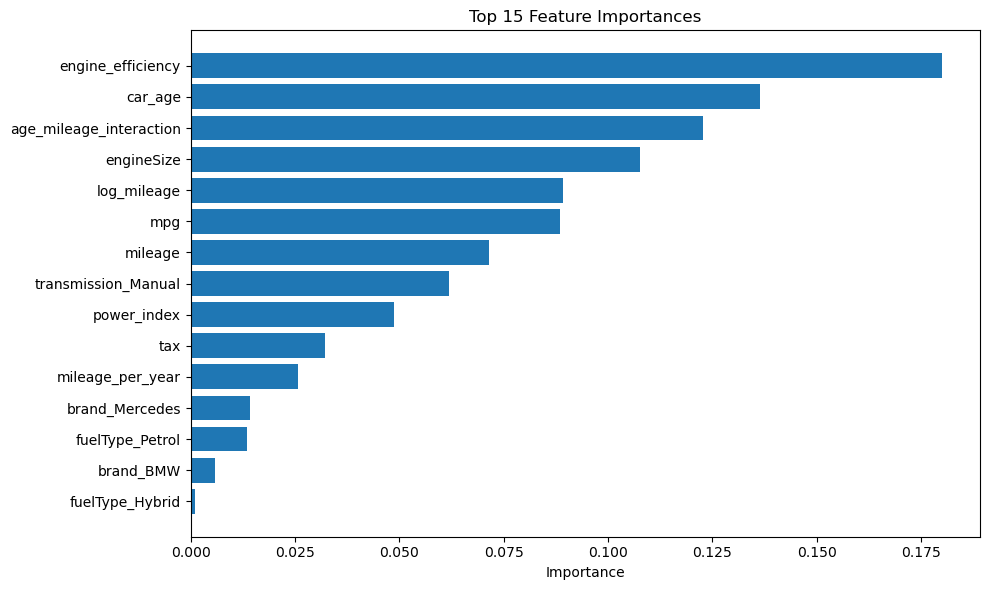

In [ ]:
# === 4c. Generate Out-of-Fold Predictions for Stacking ===
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(df))  # Store OOF predictions

for train_idx, val_idx in kf.split(df):
    # Get raw data for this fold
    train_fold_raw = df.iloc[train_idx].copy()
    val_fold_raw = df.iloc[val_idx].copy()
    
    # Create and fit pipeline on fold training data
    fold_pipeline = PreprocessingPipeline(
        use_log_target=False,
        drop_low_importance=True,
        encode_data=True
    )
    train_fold_processed = fold_pipeline.fit_transform(train_fold_raw)
    X_tr = train_fold_processed.drop(columns=["price"])
    y_tr = train_fold_processed["price"]
    
    # Transform validation fold
    val_fold_processed = fold_pipeline.transform(val_fold_raw)
    X_val = val_fold_processed.drop(columns=["price"], errors='ignore')
    y_val = val_fold_raw["price"].values  # Use original target
    
    # Train model
    fold_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        max_features='sqrt',
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    fold_model.fit(X_tr, y_tr)
    oof_preds[val_idx] = fold_model.predict(X_val)

# Save OOF predictions
pd.DataFrame({"rf_oof_pred": oof_preds}).to_csv("../results/rf_oof_train_preds.csv", index=False)
print("Saved RF OOF predictions to ../results/rf_oof_train_preds.csv")

In [ ]:
# === 5. Hyperparameter tuning using GridSearchCV ===
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='neg_root_mean_squared_error'
)

grid_search.fit(X_train, y_train)
rf_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

['../models/random_forest_tuned.joblib']

In [ ]:
# === 6. Predict and evaluate ===
y_pred = rf_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: ${rmse:.2f}")
print(f"Random Forest R² Score: {r2:.3f}")

/Users/leonardogonnelli/Desktop/Business Analytics and Data Science/Assignments/Assignment 2nd trial/src/preprocess/outlier_handling.py:8: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].clip(lower, upper)


In [ ]:
# === 6b. Feature Importance Analysis ===
import matplotlib.pyplot as plt

# Create a DataFrame of feature importances
importances_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
print("\nTop 15 Features by Importance:")
print(importances_df.head(15))

# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(importances_df.head(15)["Feature"][::-1], importances_df.head(15)["Importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

✅ Submission saved to: ../results/submission.csv


In [ ]:
# === 8. Save the tuned model ===
import joblib
joblib.dump(rf_model, "../models/random_forest_tuned.joblib")


In [ ]:
# === 9. Load test data and preprocess ===
from src.load_data import load_test_data
test_df = load_test_data()
# Use the same pipeline that was fitted on training data
test_processed = pipeline.transform(test_df)


In [ ]:
# === 10. Predict and save Kaggle submission ===
test_preds = rf_model.predict(test_processed)
submission = pd.DataFrame({
    "ID": test_df["ID"],
    "Actual": test_preds
})
submission.to_csv("../results/tuned_rf_submission.csv", index=False)
print("✅ Submission saved to: ../results/tuned_rf_submission.csv")
